<a href="https://colab.research.google.com/github/NSR9/Extensive-Vision-AI/blob/main/Assignment_7/Assignment_7_nb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/albumentations-team/albumentations.git


  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-r4d9ccce
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-r4d9ccce
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=915aec3daa341da9d0995405196ae76f21f2a2cc787123abfba65eb48a695ba1
  Stored in directory: /tmp/pip-ephem-wheel-cache-099vybzw/wheels/e2/85/3e/2a40fac5cc1f43ced656603bb2fca1327b30ec7de1b1b66517
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

SEED = 1


# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Batch_size = 32
if cuda:
  Batch_size = 64
  

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=Batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=Batch_size)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True



Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


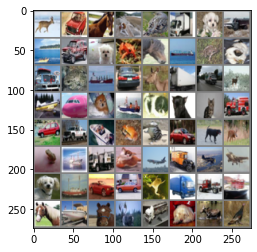

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))


In [7]:
class Net(nn.Module):
    def __init__(self):
      
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),# 32 32
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),# 32 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
        )
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False) # 32 32
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 32 30
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 30 28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 28 26
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
        )
        # dilation
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = (3, 3), stride = 1, padding = 0, dilation=2), # 26 22
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 22 20
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.1),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),# 20 18
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),# 18 16
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.1),
        )

        self.trans3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3, 3), stride = 2, padding = 0), # 16 7
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False) # 7 7
        )

        self.conv4 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),# 7 5
              nn.ReLU(),
              nn.BatchNorm2d(32),
              nn.Dropout(0.1),
              
              nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),# 5 3
            )
        
        self.avgpool2d = nn.AvgPool2d(kernel_size=3)

        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.trans3(x)
        x = self.conv4(x)
        x = self.avgpool2d(x)
        x = self.conv5(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [8]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           2,048
           Conv2d-10           [-1, 32, 30, 30]           9,216
             ReLU-11           [-1, 32, 30, 30]               0
      BatchNorm2d-12           [-1, 32, 30, 30]              64
          Dropout-13           [-1, 32, 30, 30]               0
           Conv2d-14           [-1, 32,

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [10]:
minibatches = int(len(trainset)/Batch_size)
minibatches

781

In [12]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    processed = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs,labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels) # CrossEntropyLoss
        loss.backward()
        optimizer.step() # SGD

        # print statistics
        running_loss += loss.item()

        pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        processed += len(inputs)

        if i == minibatches:    # print every  mini-batches
            print('[%d, %5d] loss: %.3f Acc: %.3f' %(epoch + 1, i + 1, running_loss / 2000,100*correct/processed ))
            running_loss = 0.0

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[1,   782] loss: 0.564 Acc: 47.122
[2,   782] loss: 0.484 Acc: 55.404
[3,   782] loss: 0.437 Acc: 59.986
[4,   782] loss: 0.407 Acc: 62.882
[5,   782] loss: 0.381 Acc: 65.166
[6,   782] loss: 0.360 Acc: 67.274
[7,   782] loss: 0.344 Acc: 68.718
[8,   782] loss: 0.328 Acc: 70.300
[9,   782] loss: 0.316 Acc: 71.214
[10,   782] loss: 0.306 Acc: 72.432
[11,   782] loss: 0.295 Acc: 73.256
[12,   782] loss: 0.285 Acc: 74.054
[13,   782] loss: 0.277 Acc: 75.048
[14,   782] loss: 0.268 Acc: 75.702
[15,   782] loss: 0.261 Acc: 76.660
[16,   782] loss: 0.254 Acc: 77.160
[17,   782] loss: 0.249 Acc: 77.650
[18,   782] loss: 0.245 Acc: 77.956
[19,   782] loss: 0.239 Acc: 78.526
[20,   782] loss: 0.233 Acc: 78.992
[21,   782] loss: 0.228 Acc: 79.538
[22,   782] loss: 0.224 Acc: 79.824
[23,   782] loss: 0.220 Acc: 80.114
[24,   782] loss: 0.214 Acc: 80.722
[25,   782] loss: 0.210 Acc: 80.986
[26,   782] loss: 0.205 Acc: 81.438
[27,   782] loss: 0.203 Acc: 81.734
[28,   782] loss: 0.201 Acc: 81.900
[

In [13]:

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.3f %%' % (
    100 * correct / total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on the 10000 test images: 78.360 %


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of plane : 84 %
Accuracy of   car : 91 %
Accuracy of  bird : 63 %
Accuracy of   cat : 58 %
Accuracy of  deer : 76 %
Accuracy of   dog : 75 %
Accuracy of  frog : 76 %
Accuracy of horse : 77 %
Accuracy of  ship : 93 %
Accuracy of truck : 84 %
